In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-22 18:34:46.779379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 18:34:47.217227: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 18:34:47.232545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 18:34:47.232577: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_df = pd.read_csv('train_2Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_2Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateQModel(shape):
    x = x_in = Input(shape)
    x = QDense(units = 64, 
               kernel_quantizer="quantized_bits(bits = 8,integer = 6,symmetric=1)",
               use_bias= True,
               bias_quantizer= "quantized_bits(bits = 8,integer = 6,symmetric=1)",
               name = "dense1")(x)
    x = QActivation(activation="quantized_relu(bits = 8, integer = 6, use_sigmoid = 1)", 
                    name="relu1")(x)
    x = BatchNormalization()(x)
    x = QDense(units = 2,
               kernel_quantizer="quantized_bits(bits = 8,integer = 6,symmetric=1)", 
               use_bias= True,
               bias_quantizer= "quantized_bits(bits = 8,integer = 6,symmetric=1)",
               name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=custom_loss)

model.summary()

2022-11-22 18:35:46.510604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 18:35:46.510744: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 18:35:46.510823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2022-11-22 18:35:46.541878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168)]             0         
                                                                 
 dense1 (QDense)             (None, 64)                10816     
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 11,202
Trainable params: 11,074
Non-trainable params: 128
_______________________________________________________

In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=2048,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
391/391 [==============================] - 9s 15ms/step - loss: 16.3260 - val_loss: 16.6420
Epoch 2/1000
391/391 [==============================] - 5s 13ms/step - loss: 9.2809 - val_loss: 5.1795
Epoch 3/1000
391/391 [==============================] - 5s 13ms/step - loss: 5.7778 - val_loss: 5.0901
Epoch 4/1000
391/391 [==============================] - 5s 12ms/step - loss: 5.0973 - val_loss: 4.9462
Epoch 5/1000
391/391 [==============================] - 5s 13ms/step - loss: 4.8681 - val_loss: 4.7559
Epoch 6/1000
391/391 [==============================] - 5s 13ms/step - loss: 4.7162 - val_loss: 4.6261
Epoch 7/1000
391/391 [==============================] - 5s 12ms/step - loss: 4.6217 - val_loss: 4.6099
Epoch 8/1000
391/391 [==============================] - 5s 13ms/step - loss: 4.5307 - val_loss: 4.5507
Epoch 9/1000
391/391 [==============================] - 5s 13ms/step - loss: 4.4421 - val_loss: 4.4172
Epoch 10/1000
391/391 [==============================] - 5s 13ms/step -

/tmp/ipykernel_182278/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


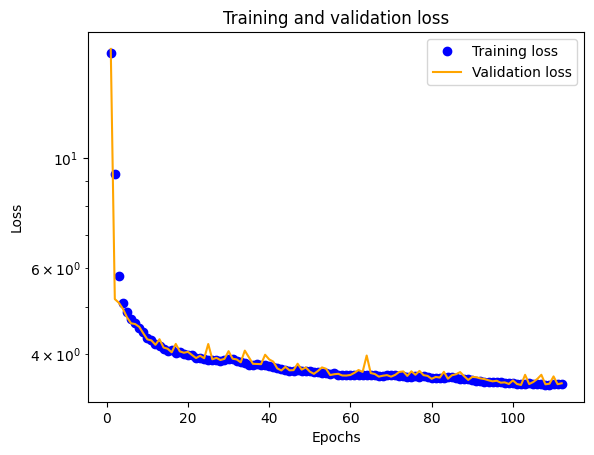

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
model.save('models_2Dx/gauss8bit.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_2DxGauss8bit.csv",header=False,index=False)

15625/15625 [==============================] - 45s 3ms/step


In [12]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

0.9222502460052158 10.242954396676431


In [13]:
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])
print(np.mean(uncertainty),np.std(uncertainty))

2.3534064 2.6248715


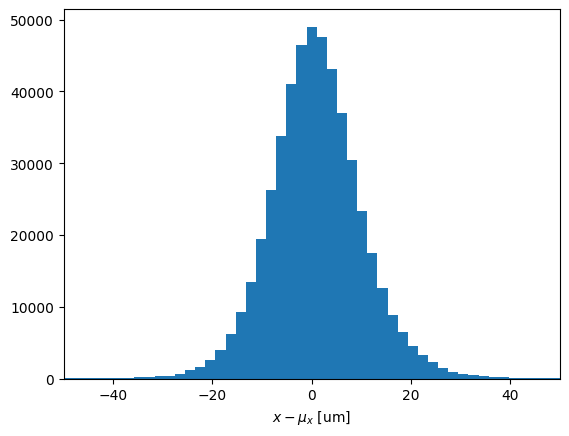

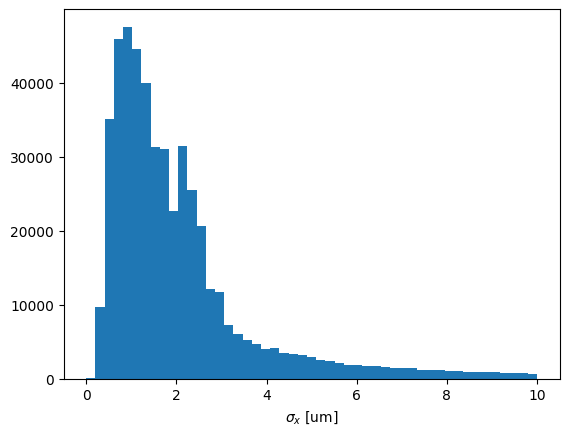

In [14]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim(-50,50)
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,10,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [15]:
pulls = residuals/p_test[:,1]
print(np.mean(pulls),np.std(pulls))

4.625384801143624 1347.0036030511867


Text(0.5, 0, 'pull')

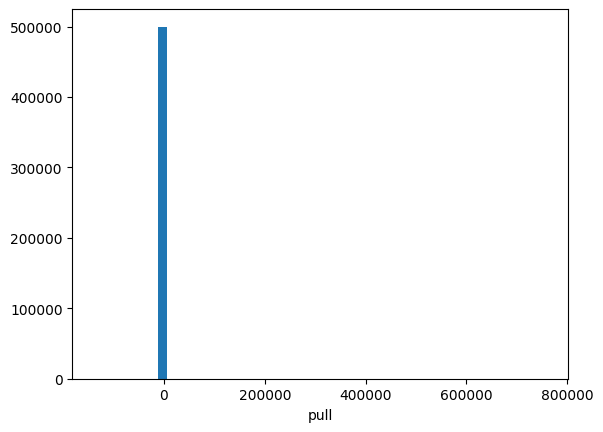

In [16]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [17]:
df_2d8 = pd.read_csv('test_2DxGauss8bit.csv',header=None,names=['mu','sigma','xtrue'])
df_2d6 = pd.read_csv('test_2DxGauss6bit.csv',header=None,names=['mu','sigma','xtrue'])
df_2d5 = pd.read_csv('test_2DxGauss5bit.csv',header=None,names=['mu','sigma','xtrue'])
df_2d = pd.read_csv('test_2DxGauss.csv',header=None,names=['mu','sigma','xtrue'])

Text(0.5, 0, '$\\mu_x$ [um]')

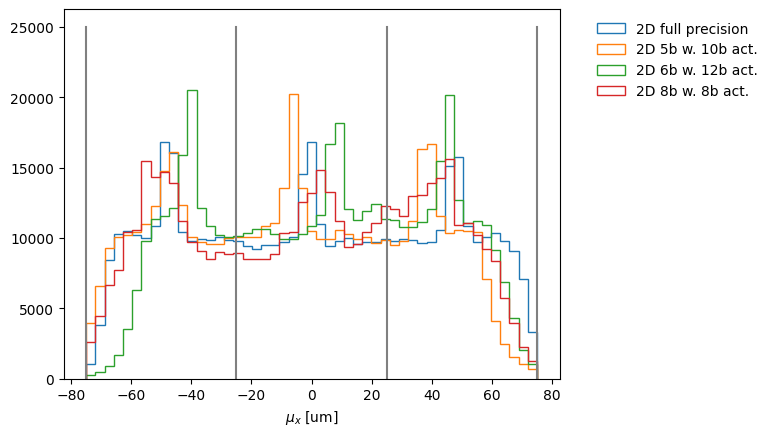

In [18]:
plt.hist(df_2d['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D full precision');
plt.hist(df_2d5['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 5b w. 10b act.');
plt.hist(df_2d6['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 6b w. 12b act.');
plt.hist(df_2d8['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 8b w. 8b act.');

plt.plot([-75,-75],[0,25000],color='gray')
plt.plot([-25,-25],[0,25000],color='gray')
plt.plot([25,25],[0,25000],color='gray')
plt.plot([75,75],[0,25000],color='gray')

plt.legend(frameon=False,bbox_to_anchor=(1.05,1))
plt.xlabel(r'$\mu_x$ [um]')

Text(0.5, 0, '$\\mu_x-x$ [um]')

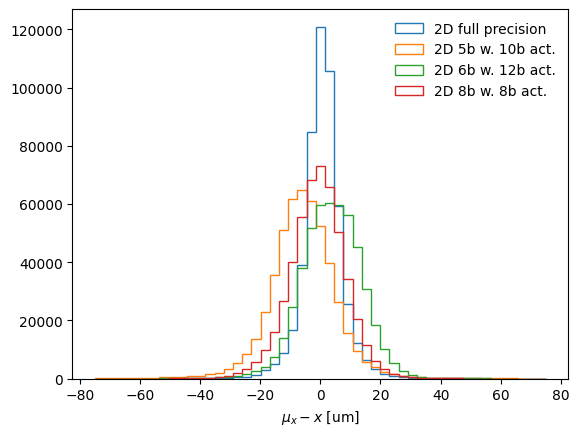

In [19]:
plt.hist(df_2d['mu']-df_2d['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D full precision');
plt.hist(df_2d5['mu']-df_2d5['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 5b w. 10b act.');
plt.hist(df_2d6['mu']-df_2d6['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 6b w. 12b act.');
plt.hist(df_2d8['mu']-df_2d8['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'2D 8b w. 8b act.');

plt.legend(frameon=False)
plt.xlabel(r'$\mu_x-x$ [um]')

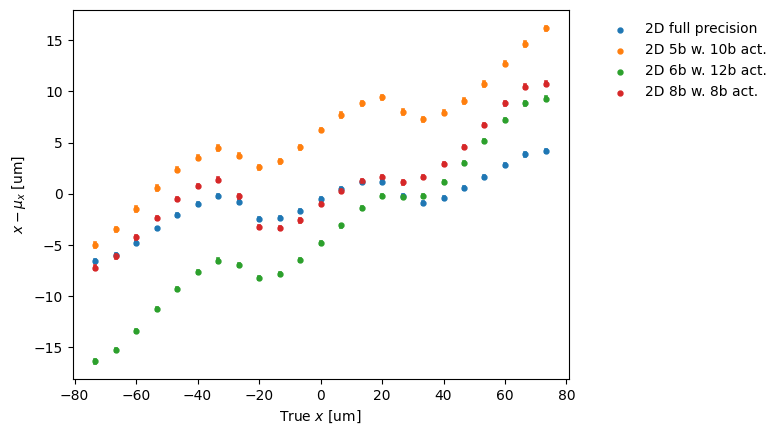

In [20]:
sns.regplot(x=df_2d['xtrue'],y=df_2d['xtrue']-df_2d['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D full precision')
sns.regplot(x=df_2d['xtrue'],y=df_2d5['xtrue']-df_2d5['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 5b w. 10b act.')
sns.regplot(x=df_2d['xtrue'],y=df_2d6['xtrue']-df_2d6['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 6b w. 12b act.')
sns.regplot(x=df_2d['xtrue'],y=df_2d8['xtrue']-df_2d8['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 8b w. 8b act.')

plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

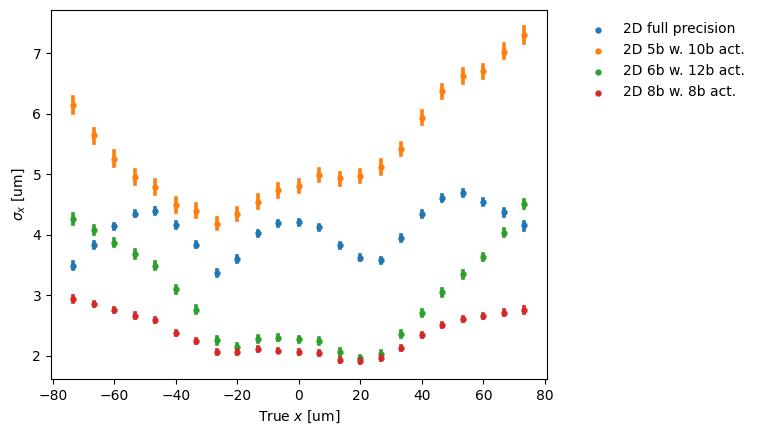

In [21]:
sns.regplot(x=df_2d['xtrue'],y=df_2d['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D full precision')
sns.regplot(x=df_2d5['xtrue'],y=df_2d5['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 5b w. 10b act.')
sns.regplot(x=df_2d6['xtrue'],y=df_2d6['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 6b w. 12b act.')
sns.regplot(x=df_2d8['xtrue'],y=df_2d8['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 8b w. 8b act.')

plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

Text(0.5, 0, '$\\sigma_x$ [um]')

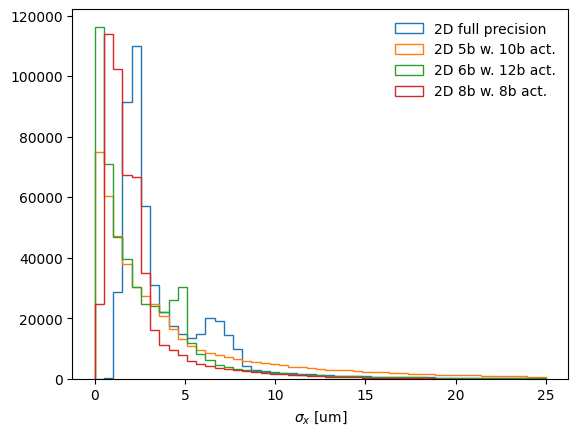

In [22]:
plt.hist(df_2d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D full precision');
plt.hist(df_2d5['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D 5b w. 10b act.');
plt.hist(df_2d6['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D 6b w. 12b act.');
plt.hist(df_2d8['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'2D 8b w. 8b act.');

plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

In [23]:
df_1d8 = pd.read_csv('test_1DxGauss8bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d6 = pd.read_csv('test_1DxGauss6bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d5 = pd.read_csv('test_1DxGauss5bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d = pd.read_csv('test_1DxGauss.csv',header=None,names=['mu','sigma','xtrue'])

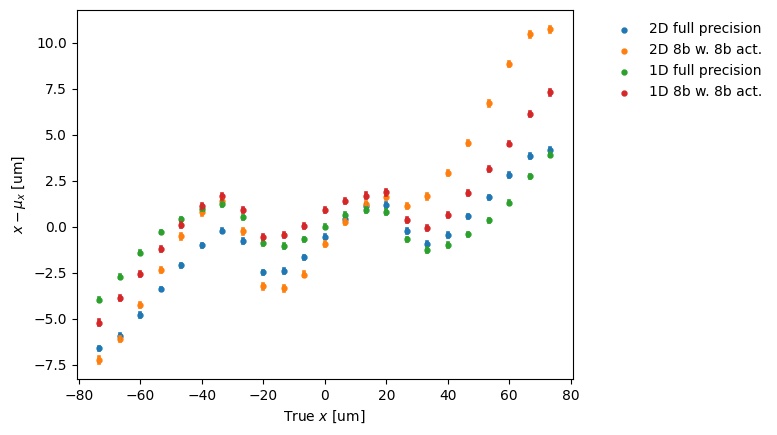

In [24]:
sns.regplot(x=df_2d['xtrue'],y=df_2d['xtrue']-df_2d['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D full precision')
#sns.regplot(x=df_2d['xtrue'],y=df_2d5['xtrue']-df_2d5['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 5b w. 10b act.')
#sns.regplot(x=df_2d['xtrue'],y=df_2d6['xtrue']-df_2d6['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 6b w. 12b act.')
sns.regplot(x=df_2d['xtrue'],y=df_2d8['xtrue']-df_2d8['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 8b w. 8b act.')
sns.regplot(x=df_1d['xtrue'],y=df_1d['xtrue']-df_1d['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D full precision')
#sns.regplot(x=df_1d['xtrue'],y=df_1d5['xtrue']-df_1d5['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 5b w. 10b act.')
#sns.regplot(x=df_1d['xtrue'],y=df_1d6['xtrue']-df_1d6['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 6b w. 12b act.')
sns.regplot(x=df_1d['xtrue'],y=df_1d8['xtrue']-df_1d8['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 8b w. 8b act.')

plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

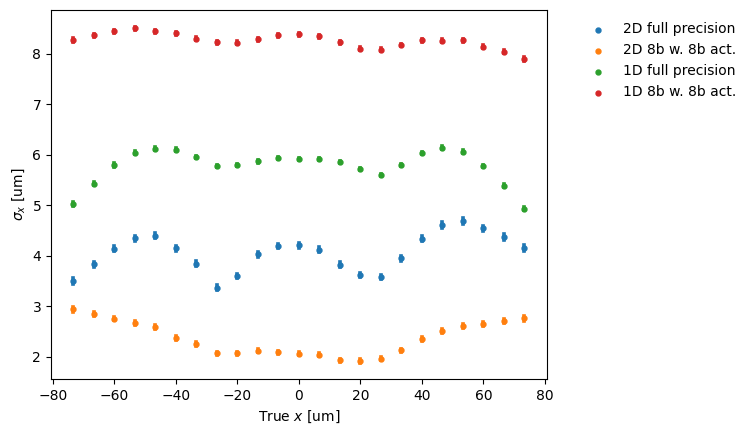

In [25]:
sns.regplot(x=df_2d['xtrue'],y=df_2d['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D full precision')
#sns.regplot(x=df_2d5['xtrue'],y=df_2d5['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 5b w. 10b act.')
#sns.regplot(x=df_2d6['xtrue'],y=df_2d6['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 6b w. 12b act.')
sns.regplot(x=df_2d8['xtrue'],y=df_2d8['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'2D 8b w. 8b act.')
sns.regplot(x=df_1d['xtrue'],y=df_1d['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D full precision')
#sns.regplot(x=df_1d5['xtrue'],y=df_1d5['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 5b w. 10b act.')
#sns.regplot(x=df_1d6['xtrue'],y=df_1d6['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 6b w. 12b act.')
sns.regplot(x=df_1d8['xtrue'],y=df_1d8['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 8b w. 8b act.')

plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

In [26]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_182278/2940326780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())


8.200166

In [27]:
max(np.array(model.layers[3].get_weights()).flatten()[0].flatten())

1.0